In [26]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt

In [27]:
# node class
class Node:
    def __init__(self, leaf=True, feature_name=None, decision_boundary=None, left=None, right=None, value=None ):
        self.feature_name = feature_name
        self.decision_boundary = decision_boundary
        self.left = left
        self.right = right
        self.value = value
        self.is_leaf = leaf # can be ignored

In [28]:
# Decision Tree class
class DecisionTree:
    def __init__(self):
        self.root = None

    def entropy(self, y):
        unique_class_occurrences = np.bincount(y)
        entropy = 0
        for c in unique_class_occurrences:
            if c != 0:
                p_i = c / len(y)
                entropy -= p_i * math.log2(p_i)
        return entropy

    def information_gain(self, X_column, threshold, y):
        left_indices = np.where(X_column <= threshold)[0]
        right_indices = np.where(X_column > threshold)[0]
        
        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0
        
        y_left = y[left_indices]
        y_right = y[right_indices]

        p_left = len(y_left) / len(y)
        p_right = len(y_right) / len(y)

        gain = self.entropy(y) - (p_left * self.entropy(y_left) + p_right * self.entropy(y_right))

        return gain

    def most_occuring_label(self, y):
        return np.bincount(y).argmax()

    def choose_best_split(self, X, y):
        optimal_gain = -1
        best_feature = None
        best_split_for_feature = None

        for i in range(X.shape[1]):
            col = X[:, i]
            unique_vals = np.unique(col)
            for j in range(len(unique_vals) - 1):
                mean = (unique_vals[j] + unique_vals[j + 1]) / 2
                gain = self.information_gain(col, mean, y)

                if gain > optimal_gain:
                    optimal_gain = gain
                    best_feature = i
                    best_split_for_feature = mean

        return best_feature, best_split_for_feature

    def create_tree(self, X, y, n_min):
        if len(np.unique(y)) == 1 or len(y) < n_min:
            return Node(leaf=True, value=self.most_occuring_label(y))

        best_feature, best_split_for_feature = self.choose_best_split(X, y)

        if best_feature is None:
            return Node(leaf=True, value=self.most_occuring_label(y))

        left_indices = np.where(X[:, best_feature] <= best_split_for_feature)[0]
        right_indices = np.where(X[:, best_feature] > best_split_for_feature)[0]

        left_child = self.create_tree(X[left_indices], y[left_indices], n_min)
        right_child = self.create_tree(X[right_indices], y[right_indices], n_min)

        return Node(leaf=False, feature_name=best_feature, decision_boundary=best_split_for_feature, left=left_child, right=right_child)

    def fit(self, X, y, n_min):
        self.root = self.create_tree(X, y, n_min)

    def predict_one_row(self, node, row):
        if node.is_leaf:
            return node.value

        if row[node.feature_name] <= node.decision_boundary:
            return self.predict_one_row(node.left, row)
        else:
            return self.predict_one_row(node.right, row)

    def predict(self, X):
        y_pred = [self.predict_one_row(self.root, row) for row in X]
        return np.array(y_pred)

In [29]:
# K-fold
def accuracy_through_cross_validation(X, y, n_min_values):
    results = []

    for n_min in n_min_values:
        accuracies = []
        kf = KFold(n_splits=10, shuffle=True, random_state=42)

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            tree = DecisionTree()
            tree.fit(X_train, y_train, n_min)

            y_pred = tree.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

        avg_accuracy = np.mean(accuracies)
        std_dev_accuracy = np.std(accuracies)

        results.append({
            'n_min': n_min,
            'average_accuracy': avg_accuracy,
            'std_dev': std_dev_accuracy
        })

    return pd.DataFrame(results)

In [30]:
from sklearn.datasets import load_iris
iris_data = load_iris()
X_iris = iris_data['data']
y_iris = iris_data['target']

spambase_data = pd.read_csv("spambase.csv")
X_spambase = spambase_data.iloc[:, :-1].values
y_spambase = spambase_data.iloc[:, -1].values

# define n_min values for both datasets
n_min_values_iris = [5, 10, 15, 20]
n_min_values_spambase = [5, 10, 15, 20, 25]

In [31]:
iris_results = accuracy_through_cross_validation(X_iris, y_iris, n_min_values_iris)
spambase_results = accuracy_through_cross_validation(X_spambase, y_spambase, n_min_values_spambase)

Iris Dataset Results:
   n_min  average_accuracy   std_dev
0      5          0.933333  0.051640
1     10          0.946667  0.049889
2     15          0.946667  0.049889
3     20          0.946667  0.049889

Spambase Dataset Results:
   n_min  average_accuracy   std_dev
0      5          0.921304  0.013742
1     10          0.919565  0.013259
2     15          0.921957  0.013764
3     20          0.922609  0.015682
4     25          0.921522  0.015810


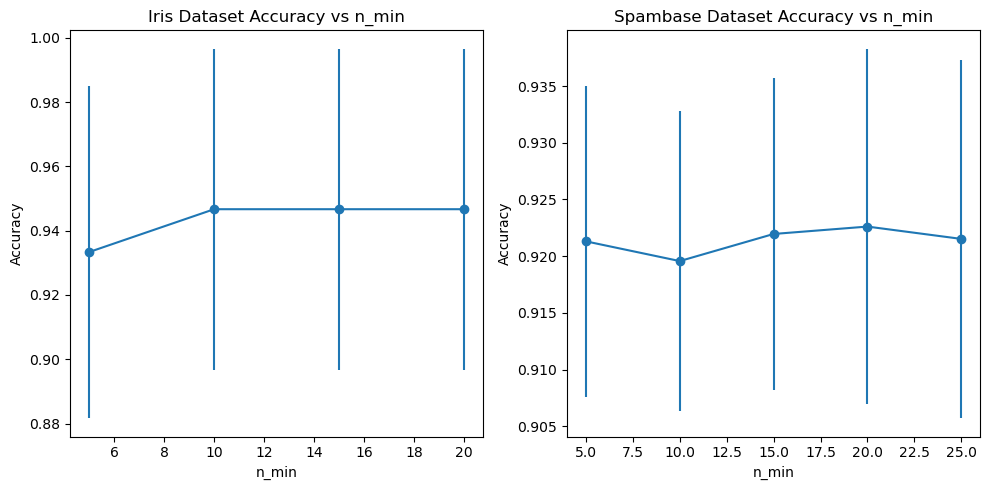

In [32]:
print("Iris Dataset Results:")
print(iris_results)

print("\nSpambase Dataset Results:")
print(spambase_results)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.errorbar(iris_results['n_min'], iris_results['average_accuracy'], yerr=iris_results['std_dev'], fmt='-o')
plt.title("Iris Dataset Accuracy vs n_min")
plt.xlabel('n_min')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.errorbar(spambase_results['n_min'], spambase_results['average_accuracy'], yerr=spambase_results['std_dev'], fmt='-o')
plt.title("Spambase Dataset Accuracy vs n_min")
plt.xlabel('n_min')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Decision Tree Implementation for Classification with Early Stopping

## Introduction

Decision tree learning is one of the most widely used predictive modeling techniques in machine learning. It can be used for both classification and regression tasks. Decision trees are hierarchical models where decisions or classifications are made by asking a series of questions, each question corresponding to a split in the data. In the case of classification trees, the aim is to predict discrete class labels, while in regression trees, the target values are continuous.

In this project, we focus on **classification trees** and implement a decision tree from scratch using **binary splits** for numerical features. We will use two datasets, **Iris** and **Spambase**, to demonstrate the effectiveness of the decision tree classifier and will evaluate the results using **10-fold cross-validation**. Additionally, an **early stopping** criterion will be applied to prevent overfitting by limiting the minimum number of instances at a leaf node.

### Key Concepts

1. **Entropy**: This measures the uncertainty or impurity in a dataset. Lower entropy indicates that the data is more homogeneous (i.e., belongs to the same class). In decision tree learning, entropy is used to find the most informative feature to split the data at each step.

2. **Information Gain**: This measures the reduction in entropy after splitting a dataset based on a specific feature. The feature that provides the highest information gain is selected for the split at each node of the tree.

3. **Early Stopping**: We impose a limit on the minimum number of instances at a leaf node (`n_min`). This prevents the tree from growing too deep and overfitting the training data. By limiting `n_min`, we ensure that nodes with very few instances are not split further.

## Dataset Description

### 1. **Iris Dataset**:
The Iris dataset is a well-known dataset used for multiclass classification. It contains 150 samples, each describing a type of Iris flower. The goal is to predict the species of Iris flower (setosa, versicolor, or virginica) based on four features:
- Sepal length
- Sepal width
- Petal length
- Petal width

### 2. **Spambase Dataset**:
The Spambase dataset is used for binary classification to determine whether an email is spam or not. It contains approximately 4600 email samples, each represented by multiple features describing the content of the email (e.g., frequency of certain words or characters). The objective is to classify emails as either spam (1) or not spam (0).

## Project Workflow

### 1. **Node Class**:
The `Node` class represents a single node in the decision tree. It contains information about:
- The feature used to split the data.
- The decision boundary for the split.
- Pointers to the left and right child nodes.
- The predicted value for leaf nodes (class label).

### 2. **DecisionTree Class**:
The `DecisionTree` class contains methods for building and training the decision tree. Key methods include:
- `entropy`: Calculates the entropy of a given dataset based on the class labels.
- `information_gain`: Computes the information gain for a given feature and split threshold.
- `choose_best_split`: Iterates through all features and potential split points to find the best split using information gain.
- `create_tree`: Recursively builds the decision tree by selecting the best split at each node.
- `fit`: Fits the decision tree to the training data by calling `create_tree`.
- `predict`: Predicts the class label for new data points by traversing the tree.

### 3. **Cross-Validation**:
We implement **10-fold cross-validation** to evaluate the performance of the decision tree for different values of `n_min`. In 10-fold cross-validation, the dataset is divided into 10 equal parts (or folds). For each fold, the model is trained on 9 folds and tested on the remaining fold. This process is repeated 10 times, and the average accuracy and standard deviation across the folds are reported.

### 4. **Hyperparameter Tuning**:
The hyperparameter `n_min` is critical to prevent overfitting. For both the Iris and Spambase datasets, we experiment with different values of `n_min` to find the best setting. The values tested are:
- For Iris: `n_min = {5, 10, 15, 20}`
- For Spambase: `n_min = {5, 10, 15, 20, 25}`

### 5. **Evaluation Metrics**:
We use **accuracy** as the primary evaluation metric, which is the proportion of correct predictions out of the total number of instances. We report the **average accuracy** and **standard deviation** across the 10 folds for each value of `n_min`.

### 6. **Visualization**:
The accuracy results for each value of `n_min` are visualized using line plots with error bars to represent the standard deviation. This helps in understanding the effect of the `n_min` parameter on model performance.
